# [LEGALST-190] Lab 4/17: Feature Selection

This lab will cover feature selection in order to train a machine learning model using `scikit-learn`.

Estimated time: 35 minutes

### Table of Contents
[The Data](#section data)<br>
1 - [First Model](# section 1)<br>
2 - [Intro to Feature Removal Intuition](#section 2)<br>
3 - [Improving Your Model](#section 3)<br>


In [1]:
# load all libraries 

import numpy as np
from datascience import *
import datetime as dt
import pandas as pd
import seaborn as sns

#matplotlin
%matplotlib inline
import matplotlib.pyplot as plt

#scikit-learn
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn import preprocessing


from sklearn import metrics

## The Data: Bike Sharing<a id='section data'></a>

By now, I'm sure you have been exposed to bike sharing dataset several times in this lab. This lab's data describes one such bike sharing system in Washington D.C., from UC Irvine's Machine Learning Repository.

Information about the dataset: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [2]:
bike = pd.read_csv(('data/day.csv'))

# reformat the date column to integers that represent the day of the year, 001-366
bike['dteday'] = pd.to_datetime(bike['dteday'].unique()).strftime('%j')

bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,004,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,005,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


If you need to become familiar with this data set again, feel free to refer back to lab 2-22.

## Section 1: First Model

Before defining a model, it is good practice to determine which features to select. This process is often accompanied by lots of Exploratory Data Analysis (EDA). First we will look at which features correlate to our target feature (`cnt`).


**Question 1.1:** Plot a few EDA yourself to become familar with the correlation values between certain features with the number of riders.

**hint:** I recommend looking into heat maps

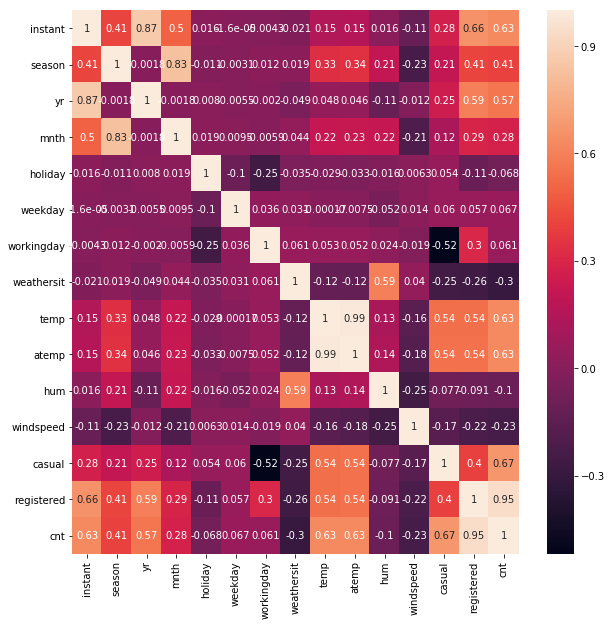

In [3]:
corrmat = bike.corr()
plt.figure(figsize=(10,10))
g = sns.heatmap(bike.corr(),annot=True)
g

**Question 1.2:** Looking at your EDA, how will that help you select which features to use?

*Answer:* sample answer
- Looking at the correlations between all features and cnt, I would pick the ones with correlation values higher than 0.50

**Question 1.3:** List out features that would be important to select for your model. Make sure to not include registered or casual riders in your features list.

In [4]:
features = ["instant", "yr", "temp", "atemp"]
features

['instant', 'yr', 'temp', 'atemp']

**Question 1.4:** Now create a `linear regression` model with the features that you have selected to predict the number of riders(`cnt`). 

First, separate your data into two parts, a dataframe containing the features used to make our prediction (X) and an array of the true values (y). To start, let's predict the total number of riders (y) using every feature that isn't a rider count (X). Then split the train_size and test_size containing 80% and 20% of the data respectively. Scikit-learn's `test_train_split function` will help here.

You can refer back to lab 2-22 if needed.

*Note that Lasso and Ridge models would use the same steps below.*

In [6]:
# the features used to predict riders
X = bike[features]

# the number of riders
y = bike['cnt']

# set the random seed
np.random.seed(10)

# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

In [7]:
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

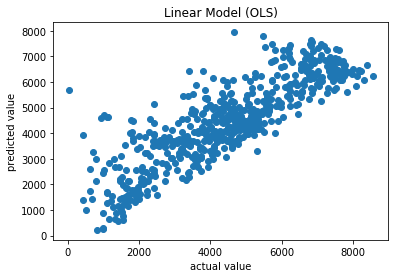

In [8]:
# predict the number of riders

lin_pred = lin_model.predict(X_train)

# plot the residuals on a scatter plot
plt.scatter(y_train, lin_pred)

plt.title('Linear Model (OLS)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

In order to check the error between the predicted values and the actual values, I have defined the root mean square error for you. Recall that the equation is the mean squared error of a predicted set of values.

In [9]:
def rmse(pred, actual):
    error = np.sqrt(np.mean((pred - actual) ** 2))
    return print('Root Mean Square Error: ', error)

**Question 1.5:** What is the rmse for both the prediction of X_train and X_test?

In [10]:
rmse(lin_pred, y_train)

Root Mean Square Error:  1019.8195957


In [11]:
#predict your X_test here
lin_pred = lin_model.predict(X_test)

In [12]:
rmse(lin_pred, y_test)

Root Mean Square Error:  1221.66817805


## Section 2: Introduction to Feature Removal Intuition<a id = 'section 2'></a>

As a good rule of thumb, we typically wish to pick features that have roughly more than a 0.50 correlation with the target column. Also, even though not relevant to the bike sharing dataset, it is often best to remove columns that contain a high ratio of null values. However, sometimes null values represent 0 instead of data actually missing! So always be on the look out when you have to clean data.

Of course, with any tedious and error prone process there is always a short cut that reduces time and human error. In part 1, you used your own intuition to pick out features that correlate the highest with the target feature. However, we can use `scikit-learn` to help pick the important features for us. 

Feature selection methods can give you useful information on the relative importance or relevance of features for a given problem. You can use this information to create filtered versions of your dataset and increase the accuracy of your model.

### Remove Features with Low Variance

In removing features with low variance, all features whose variance does not meet some threshold are removed. In order to remove features that have low variance, you must use normalization on the columns before using VarianceThreshold. This is necessary to bring all the features to same scale. Ensuring standardised feature values implicitly weights all features equally. Otherwise, the variance estimates can be misleading between higher value features and lower value features. By default, normalization is not included in the function.

In [55]:
# here we will reload the X and y values for you without the features you selected earlier
X = bike

# the number of riders
y = bike['cnt']

# set the random seed
np.random.seed(10)

# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

**Question 2.1:** What is the current shape of X_train?

In [14]:
# code answer here
X_train.shape

(584, 16)

In [15]:
# normalize your X_train
X_train = preprocessing.normalize(X_train)
X_train.shape

(584, 16)

Use `VarianceThreshold` to filter out features that match a 0.1 threshold. If your code produces an error ('No feature in X meets the variance threshold 0.10000') and you believe it is correct, try rerunning the `train_test_split` code block above and rerun the code below.

Then you can use `transform` on the X_train. This will select features that match the threshold.

In [18]:
#use VarianceThreshold 
sel = VarianceThreshold(threshold = 0.1)
sel.fit_transform(X_train)

# Subset features with transform
X_new = sel.transform(X_train)

#notice how many features are then selected compared to X_train's original features
X_new.shape

#make sure to also transform X_test so it will match dimensions of X_train
X_new_test = sel.transform(X_test)

In [19]:
#Create a new Linear Regression model for your X_new. Recall that X_new is the X_train with selected features.
new_lin_reg = LinearRegression()

# fit the model
new_lin_model = new_lin_reg.fit(X_new, y_train)

#predict X_new
new_lin_pred = new_lin_model.predict(X_new)

#predict X_new_test
new_test_pred = new_lin_model.predict(X_new_test)

**Question 2.1:** How does the number of features from X_train compare to X_new?

*Answer:*

**Question 2.2:** How does your root mean square error change compared to your model in section 1?

*Answer:*

In [20]:
rmse(new_lin_pred, y_train)

Root Mean Square Error:  1.54595389883e-12


In [21]:
rmse(new_test_pred, y_test)

Root Mean Square Error:  1.49060554669e-12


### Recursive Feature Elimiation with scikit-learn

According to [Feature Selection in Python with Scikit-Learn](https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/), recursive feature elimination works by “recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.”
     

In [54]:
# create a base classifier used to evaluate a subset of attributes
model = LinearRegression()

# create the RFE model and select 10 attributes
rfe = RFE(model, 10)
rfe.fit(X_train, y_train)

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False False False False  True False  True  True  True  True  True
  True  True  True  True]
[6 5 2 7 4 1 3 1 1 1 1 1 1 1 1 1]


In [23]:
# using rfe, predict your training set
new_pred = rfe.predict(X_train)

# what's the error?
rmse(new_pred, y_train)

Root Mean Square Error:  7.01337793968e-13


In [24]:
# now predict your test set
new_test_pred = rfe.predict(X_test)

# what's the error?
rmse(new_test_pred, y_test)

Root Mean Square Error:  8.03011882731e-13


**Question 2.3:** How does recursive feature elimination improve your error?

*Answer:* Use the rmse equation to explain.

### Feature Importance

Feature importance is selecting features that are most important from a previous classifier. For example, selecting the most important features from a number of randomized decision trees. The idea behind random trees is to use many of them to perform prediction. This helps the model to be more robust.

Methods that use ensembles of decision trees (like `Random Forest` or `Extra Trees`) can also compute the relative importance of each attribute. These importance values can be used to inform a feature selection process. In this lab, we will be using `Extra Trees`, Random forest will be introduced in the next lab.

Below shows the construction of an Extra Trees ensemble of the bike share dataset and the display of the relative feature importance.

Once you use `ExtraTreesClassifer` to create a new model, fit the model. Afterwards, you can use `SelectFromModel` to select features using the classifier. Make sure to `transform` your X_train to obtain the selected important features.

In [68]:
# Fits a number of randomized decision trees. Use 30 estimators (this value was arbitrarily chosen)
model = ExtraTreesClassifier(n_estimators = 30)

#fit your model
model.fit(X_train, y_train)

# Select the important features of previous model
sel = SelectFromModel(model, prefit=True)

# Subset features
X_new = sel.transform(X_train)

**Question 2.4:** Which method gives the best results? Check errors rates between all methods mentioned in this section.

*Answer:* Removing features with low variance gave the best performance.

In [57]:
model.fit(X_new, y_train)

rmse(model.predict(X_new), y_train)

Root Mean Square Error:  0.0


In [85]:
rmse(model.predict(X_test), y_test)

Root Mean Square Error:  489.30474068


## Section 3: Improving your model<a id = 'section 3'></a>

Since Linear Regression is not the only model option, use the above methods to fit a new model using either `Lasso` or `Ridge`.

**Question 3.1:** Within the scope of this class, what are other methods that can be used to improve estimation? Then apply the adjustments you came up with.

*Answer:* possible answers
- testing multiple models
- averging models
- stacking models
- change number of attributes in Recursive Feature Elimiation method
- increase number of estimates in Feature Importance method

In [57]:
#space to make your new model

In [ ]:
#space to plot your values

plt.scatter(y_train, ...)
plt.title('... Model')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

## Bibliography

 - Brownlee Jason, An Introduction to Feature Selection. https://machinelearningmastery.com/an-introduction-to-feature-selection/
 - Brownlee Jason, Feature Selection in Python with Scikit-Learn. https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
 - Asaithambi Sudharsan, Why, How and When to apply Feature Selection. https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2
 - Use of `Bike Share` data set adapted from UC Irvine's Machine Learning Repository. http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
 - Some code adapted from Celia Siu: https://csiu.github.io/blog/update/2017/03/06/day10.html

----
Notebook developed by: Tina Nguyen

Data Science Modules: http://data.berkeley.edu/education/modules